# Fast Super-Resolution Convolutional Neural Network

*Louis Martinez*

[Link to the paper](./Articles/fsrcnn.pdf)

In [1]:
# !wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
# !unzip -q DIV2K_train_HR.zip
# !mv DIV2K_train_HR ./DIV2K


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import SGD
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms as T

import warnings
warnings.filterwarnings('ignore')

torch.manual_seed(0)
plt.ion()

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
class DIV2KDataset(Dataset):

    def __init__(self, train_dir, hr_size, scale):
        assert hr_size % scale == 0
        self.train_dir = train_dir
        self.hr_size = hr_size
        self.lr_size = hr_size // scale
        self.imgs = os.listdir(train_dir)
        self.toFloatImage = T.Compose([T.ToTensor(), T.ConvertImageDtype(torch.float32)])

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, index):
        hr_path = os.path.join(self.train_dir, self.imgs[index])
        hr_image = Image.open(hr_path).convert('RGB')
        hr_image = T.CenterCrop(self.hr_size)(hr_image)
        lr_image = hr_image.resize((self.lr_size,)*2, resample=Image.BICUBIC)

        lr_image = self.toFloatImage(lr_image)
        hr_image = self.toFloatImage(hr_image)

        return lr_image, hr_image

In [4]:
hr_size = 648
n_pixels = hr_size**2
channels = 3
scale = 3

dataset = DIV2KDataset('DIV2K/', hr_size=hr_size, scale=scale)
val_split = 0.2
val_size = int(val_split * len(dataset))
train_size = len(dataset) - val_size

train_set, val_set = random_split(dataset, [train_size, val_size])

batch_size = 32
n_pixels_hr = train_set

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

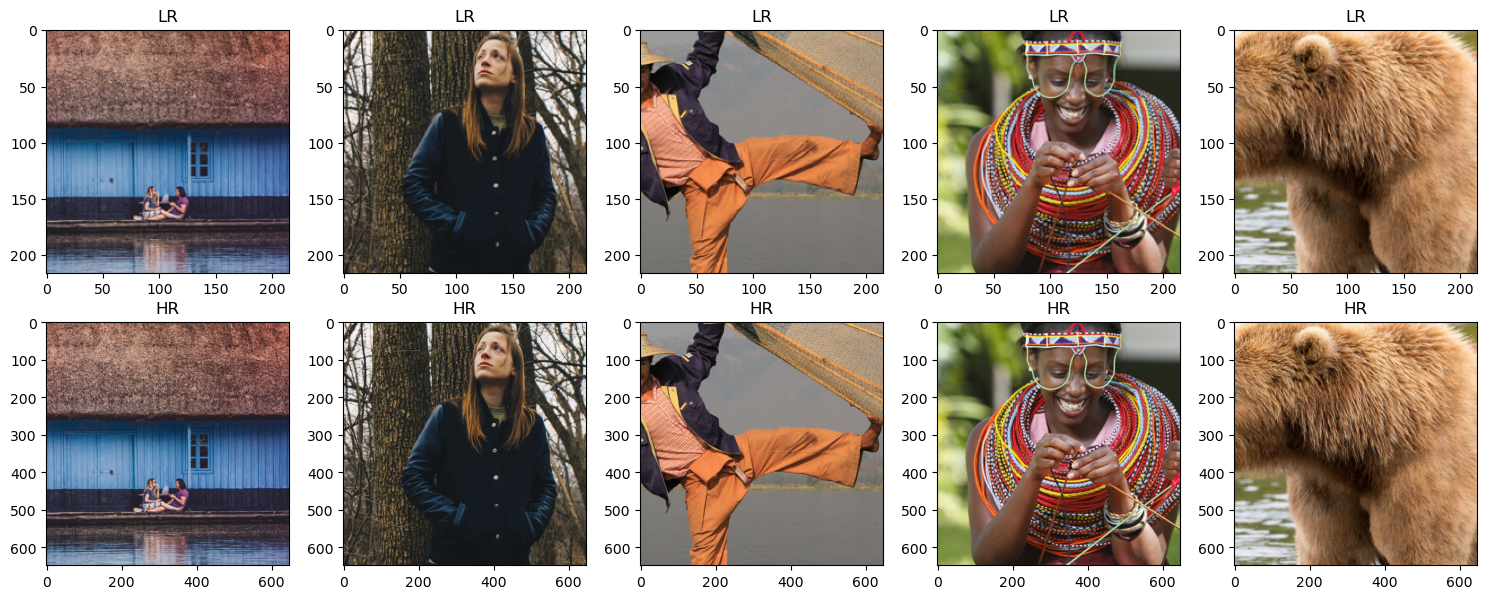

In [5]:
hr_img, lr_img = next(iter(val_loader))
fig, axes = plt.subplots(2, 5, figsize=(15,6))
ax = axes.flatten()

for i in range(5):
    ax[i].imshow(hr_img[i].permute(1,2,0))
    ax[i].set_title('LR')
    ax[i+5].imshow(lr_img[i].permute(1,2,0))
    ax[i+5].set_title('HR')

plt.tight_layout()

In [6]:
class FSRCNN(nn.Module):

    def __init__(self, d, s, m, scale):
        super(FSRCNN, self).__init__()

        self.s = s
        self.d = d
        self.m = m
        self.scale = scale

        # Feature extraction
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=self.d, kernel_size=5, padding='same')

        # Shrinking
        self.conv2 = nn.Conv2d(in_channels=self.d, out_channels=self.s, kernel_size=1, padding='same')

        # Non Linear Mapping
        self.conv3 = nn.Conv2d(in_channels=self.s, out_channels=self.s, kernel_size=3, padding='same')

        # Expanding
        self.conv4 = nn.Conv2d(in_channels=self.s, out_channels=self.d, kernel_size=1)

        # Deconvolution
        self.deconv = nn.ConvTranspose2d(in_channels=self.d, out_channels=3, kernel_size=9, stride=scale, padding=scale)
        # Initialize weights
        init.normal_(self.deconv.weight, mean=0.0, std=0.001)

    def feature_extraction(self, x):
        # print(f'Feature extraction : {x.shape}')
        return nn.LeakyReLU()(self.conv1(x))

    def shrinking(self, x):
        # print(f'Shrinking : {x.shape}')
        return nn.LeakyReLU()(self.conv2(x))

    def non_linear_mapping(self, x):
        # print(f'Non linear mapping : {x.shape}')
        for _ in range(self.m):
            x = nn.LeakyReLU()(self.conv3(x))
        return x

    def expanding(self, x):
        # print(f'Expanding : {x.shape}')
        return nn.LeakyReLU()(self.conv4(x))

    def deconvolution(self, x):
        # print(f'Deconvolution : {x.shape}')
        return self.deconv(x)

    def forward(self, x):
        x = self.feature_extraction(x)
        x = self.shrinking(x)
        x = self.non_linear_mapping(x)
        x = self.expanding(x)
        x = self.deconvolution(x)
        return x



In [7]:
# deconv_lr = 1e-4

# Separate parameters from convolution layers and params from deconvolution layer as they have different learning rates
# deconv_list = ['deconv.weight', 'deconv.bias']
# deconv_params = list(filter(lambda kv : kv[0] in deconv_list, model.named_parameters()))
# base_params = list(filter(lambda kv : kv[0] not in deconv_list, model.named_parameters()))
# optimizer = SGD(model.parameters([{'params' : base_params},{'params' : deconv_params, 'lr': deconv_lr}]), lr=conv_lr, momentum=0.9)

conv_lr = 0.01
model = FSRCNN(d=48, s=12, m=2, scale=scale).to(device)
optimizer = SGD(model.parameters(), lr=conv_lr, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer=optimizer, mode='min')
loss = nn.MSELoss()

epochs = 200
train_losses = []
val_losses = []
min_val_loss = 10_000

def validate(model, loss_func, val_loader, device):
    val_loss = 0.
    global min_val_loss

    model.eval()
    with torch.no_grad():
      for batch_idx, (lr_images, hr_images) in enumerate(val_loader):
        lr_images = lr_images.to(device)
        hr_images = hr_images.to(device)

        hr_pred = model(lr_images)

        pred_loss = loss_func(hr_images.reshape(batch_size,channels,n_pixels), hr_pred.reshape(batch_size,channels,n_pixels))
        val_loss += pred_loss

    val_losses.append(val_loss)
    scheduler.step(val_loss)

    if val_loss < min_val_loss:
      min_val_loss = val_loss
      torch.save(model.state_dict(), 'best-model.pt')
    return val_loss



def train(model, optimizer, loss, train_loader, device):
    train_loss = 0.

    model.train()
    with tqdm(total=len(train_loader), desc=f'Running epoch {epoch+1}/{epochs}') as pbar:
      for batch_idx, (lr_images, hr_images) in enumerate(train_loader):

          lr_images = lr_images.to(device)
          hr_images = hr_images.to(device)

          optimizer.zero_grad()
          hr_predicted = model(lr_images)

          pred_loss = loss(hr_images.reshape(batch_size,channels,n_pixels), hr_predicted.reshape(batch_size,channels,n_pixels))
          pred_loss.backward()
          train_loss += pred_loss.item()
          optimizer.step()

          pbar.update(1)

    train_losses.append(train_loss)
    return train_loss

In [8]:
for epoch in range(epochs):
    train_loss = train(model, optimizer, loss, train_loader, device)
    validation_loss = validate(model, loss, val_loader, device)
    print(f'Epoch {epoch+1}/{epochs:.3f} | Train loss : {train_loss} | Val loss : {validation_loss:.3f}')

Running epoch 1/200: 100%|██████████| 20/20 [01:14<00:00,  3.71s/it]


Epoch 1/200.000 | Train loss : 3.4276019856333733 | Val loss : 0.370


Running epoch 2/200: 100%|██████████| 20/20 [01:12<00:00,  3.65s/it]


Epoch 2/200.000 | Train loss : 1.5928291380405426 | Val loss : 0.391


Running epoch 3/200: 100%|██████████| 20/20 [01:13<00:00,  3.65s/it]


Epoch 3/200.000 | Train loss : 1.5232040658593178 | Val loss : 0.367


Running epoch 4/200: 100%|██████████| 20/20 [01:13<00:00,  3.66s/it]


Epoch 4/200.000 | Train loss : 1.508052371442318 | Val loss : 0.367


Running epoch 5/200: 100%|██████████| 20/20 [01:13<00:00,  3.66s/it]


Epoch 5/200.000 | Train loss : 1.5014858171343803 | Val loss : 0.367


Running epoch 6/200: 100%|██████████| 20/20 [01:13<00:00,  3.67s/it]


Epoch 6/200.000 | Train loss : 1.496075451374054 | Val loss : 0.365


Running epoch 7/200: 100%|██████████| 20/20 [01:12<00:00,  3.64s/it]


Epoch 7/200.000 | Train loss : 1.4885651618242264 | Val loss : 0.363


Running epoch 8/200: 100%|██████████| 20/20 [01:13<00:00,  3.65s/it]


Epoch 8/200.000 | Train loss : 1.476961225271225 | Val loss : 0.359


Running epoch 9/200: 100%|██████████| 20/20 [01:12<00:00,  3.61s/it]


Epoch 9/200.000 | Train loss : 1.4575993865728378 | Val loss : 0.353


Running epoch 10/200: 100%|██████████| 20/20 [01:12<00:00,  3.60s/it]


Epoch 10/200.000 | Train loss : 1.4222192764282227 | Val loss : 0.343


Running epoch 11/200: 100%|██████████| 20/20 [01:12<00:00,  3.63s/it]


Epoch 11/200.000 | Train loss : 1.3511190116405487 | Val loss : 0.318


Running epoch 12/200: 100%|██████████| 20/20 [01:12<00:00,  3.60s/it]


Epoch 12/200.000 | Train loss : 1.184951663017273 | Val loss : 0.264


Running epoch 13/200: 100%|██████████| 20/20 [01:12<00:00,  3.60s/it]


Epoch 13/200.000 | Train loss : 0.8816526122391224 | Val loss : 0.184


Running epoch 14/200: 100%|██████████| 20/20 [01:13<00:00,  3.66s/it]


Epoch 14/200.000 | Train loss : 0.586317639797926 | Val loss : 0.132


Running epoch 15/200: 100%|██████████| 20/20 [01:12<00:00,  3.60s/it]


Epoch 15/200.000 | Train loss : 0.4599056039005518 | Val loss : 0.119


Running epoch 16/200: 100%|██████████| 20/20 [01:12<00:00,  3.61s/it]


Epoch 16/200.000 | Train loss : 0.4359561037272215 | Val loss : 0.117


Running epoch 17/200: 100%|██████████| 20/20 [01:12<00:00,  3.63s/it]


Epoch 17/200.000 | Train loss : 0.43144342862069607 | Val loss : 0.117


Running epoch 18/200: 100%|██████████| 20/20 [01:11<00:00,  3.60s/it]


Epoch 18/200.000 | Train loss : 0.42827112786471844 | Val loss : 0.116


Running epoch 19/200: 100%|██████████| 20/20 [01:12<00:00,  3.60s/it]


Epoch 19/200.000 | Train loss : 0.4256342947483063 | Val loss : 0.115


Running epoch 20/200: 100%|██████████| 20/20 [01:11<00:00,  3.60s/it]


Epoch 20/200.000 | Train loss : 0.4235420562326908 | Val loss : 0.115


Running epoch 21/200: 100%|██████████| 20/20 [01:12<00:00,  3.60s/it]


Epoch 21/200.000 | Train loss : 0.4218626655638218 | Val loss : 0.114


Running epoch 22/200: 100%|██████████| 20/20 [01:13<00:00,  3.69s/it]


Epoch 22/200.000 | Train loss : 0.4203653484582901 | Val loss : 0.114


Running epoch 23/200: 100%|██████████| 20/20 [01:12<00:00,  3.64s/it]


Epoch 23/200.000 | Train loss : 0.4184785168617964 | Val loss : 0.114


Running epoch 24/200: 100%|██████████| 20/20 [01:12<00:00,  3.60s/it]


Epoch 24/200.000 | Train loss : 0.41742536425590515 | Val loss : 0.113


Running epoch 25/200: 100%|██████████| 20/20 [01:12<00:00,  3.60s/it]


Epoch 25/200.000 | Train loss : 0.4158629570156336 | Val loss : 0.113


Running epoch 26/200: 100%|██████████| 20/20 [01:12<00:00,  3.60s/it]


Epoch 26/200.000 | Train loss : 0.4142621550709009 | Val loss : 0.113


Running epoch 27/200: 100%|██████████| 20/20 [01:12<00:00,  3.62s/it]


Epoch 27/200.000 | Train loss : 0.414344884455204 | Val loss : 0.112


Running epoch 28/200: 100%|██████████| 20/20 [01:12<00:00,  3.62s/it]


Epoch 28/200.000 | Train loss : 0.41227445285767317 | Val loss : 0.112


Running epoch 29/200: 100%|██████████| 20/20 [01:11<00:00,  3.60s/it]


Epoch 29/200.000 | Train loss : 0.41126602329313755 | Val loss : 0.111


Running epoch 30/200: 100%|██████████| 20/20 [01:12<00:00,  3.61s/it]


Epoch 30/200.000 | Train loss : 0.4090092880651355 | Val loss : 0.111


Running epoch 31/200: 100%|██████████| 20/20 [01:12<00:00,  3.60s/it]


Epoch 31/200.000 | Train loss : 0.4074953403323889 | Val loss : 0.111


Running epoch 32/200: 100%|██████████| 20/20 [01:12<00:00,  3.63s/it]


Epoch 32/200.000 | Train loss : 0.40645122714340687 | Val loss : 0.110


Running epoch 33/200: 100%|██████████| 20/20 [01:13<00:00,  3.68s/it]


Epoch 33/200.000 | Train loss : 0.40514575131237507 | Val loss : 0.110


Running epoch 34/200: 100%|██████████| 20/20 [01:14<00:00,  3.71s/it]


Epoch 34/200.000 | Train loss : 0.4036370739340782 | Val loss : 0.110


Running epoch 35/200: 100%|██████████| 20/20 [01:13<00:00,  3.68s/it]


Epoch 35/200.000 | Train loss : 0.4014979749917984 | Val loss : 0.109


Running epoch 36/200: 100%|██████████| 20/20 [01:13<00:00,  3.67s/it]


Epoch 36/200.000 | Train loss : 0.40015062503516674 | Val loss : 0.109


Running epoch 37/200: 100%|██████████| 20/20 [01:15<00:00,  3.76s/it]


Epoch 37/200.000 | Train loss : 0.39883047714829445 | Val loss : 0.109


Running epoch 38/200: 100%|██████████| 20/20 [01:14<00:00,  3.74s/it]


Epoch 38/200.000 | Train loss : 0.3972870856523514 | Val loss : 0.108


Running epoch 39/200: 100%|██████████| 20/20 [01:14<00:00,  3.72s/it]


Epoch 39/200.000 | Train loss : 0.3959838952869177 | Val loss : 0.108


Running epoch 40/200: 100%|██████████| 20/20 [01:14<00:00,  3.74s/it]


Epoch 40/200.000 | Train loss : 0.3943062797188759 | Val loss : 0.108


Running epoch 41/200: 100%|██████████| 20/20 [01:13<00:00,  3.69s/it]


Epoch 41/200.000 | Train loss : 0.3931397031992674 | Val loss : 0.107


Running epoch 42/200: 100%|██████████| 20/20 [01:13<00:00,  3.66s/it]


Epoch 42/200.000 | Train loss : 0.3912123776972294 | Val loss : 0.107


Running epoch 43/200: 100%|██████████| 20/20 [01:12<00:00,  3.63s/it]


Epoch 43/200.000 | Train loss : 0.3900640085339546 | Val loss : 0.106


Running epoch 44/200: 100%|██████████| 20/20 [01:12<00:00,  3.64s/it]


Epoch 44/200.000 | Train loss : 0.38844506815075874 | Val loss : 0.106


Running epoch 45/200: 100%|██████████| 20/20 [01:12<00:00,  3.64s/it]


Epoch 45/200.000 | Train loss : 0.3866547457873821 | Val loss : 0.105


Running epoch 46/200: 100%|██████████| 20/20 [01:12<00:00,  3.64s/it]


Epoch 46/200.000 | Train loss : 0.3849761290475726 | Val loss : 0.105


Running epoch 47/200: 100%|██████████| 20/20 [01:14<00:00,  3.74s/it]


Epoch 47/200.000 | Train loss : 0.3836428076028824 | Val loss : 0.105


Running epoch 48/200: 100%|██████████| 20/20 [01:13<00:00,  3.65s/it]


Epoch 48/200.000 | Train loss : 0.3818200081586838 | Val loss : 0.104


Running epoch 49/200: 100%|██████████| 20/20 [01:12<00:00,  3.61s/it]


Epoch 49/200.000 | Train loss : 0.37984583619982004 | Val loss : 0.104


Running epoch 50/200: 100%|██████████| 20/20 [01:11<00:00,  3.59s/it]


Epoch 50/200.000 | Train loss : 0.37806509621441364 | Val loss : 0.103


Running epoch 51/200: 100%|██████████| 20/20 [01:11<00:00,  3.59s/it]


Epoch 51/200.000 | Train loss : 0.37631160020828247 | Val loss : 0.103


Running epoch 52/200: 100%|██████████| 20/20 [01:12<00:00,  3.61s/it]


Epoch 52/200.000 | Train loss : 0.37471285834908485 | Val loss : 0.102


Running epoch 53/200: 100%|██████████| 20/20 [01:12<00:00,  3.64s/it]


Epoch 53/200.000 | Train loss : 0.37288016080856323 | Val loss : 0.102


Running epoch 54/200: 100%|██████████| 20/20 [01:12<00:00,  3.61s/it]


Epoch 54/200.000 | Train loss : 0.37057550717145205 | Val loss : 0.101


Running epoch 55/200: 100%|██████████| 20/20 [01:12<00:00,  3.61s/it]


Epoch 55/200.000 | Train loss : 0.3689451776444912 | Val loss : 0.101


Running epoch 56/200: 100%|██████████| 20/20 [01:12<00:00,  3.60s/it]


Epoch 56/200.000 | Train loss : 0.36647655349224806 | Val loss : 0.100


Running epoch 57/200: 100%|██████████| 20/20 [01:12<00:00,  3.60s/it]


Epoch 57/200.000 | Train loss : 0.3642214871942997 | Val loss : 0.100


Running epoch 58/200: 100%|██████████| 20/20 [01:12<00:00,  3.63s/it]


Epoch 58/200.000 | Train loss : 0.36201019678264856 | Val loss : 0.099


Running epoch 59/200: 100%|██████████| 20/20 [01:12<00:00,  3.62s/it]


Epoch 59/200.000 | Train loss : 0.3598413160070777 | Val loss : 0.099


Running epoch 60/200: 100%|██████████| 20/20 [01:11<00:00,  3.59s/it]


Epoch 60/200.000 | Train loss : 0.35709178633987904 | Val loss : 0.098


Running epoch 61/200: 100%|██████████| 20/20 [01:12<00:00,  3.60s/it]


Epoch 61/200.000 | Train loss : 0.3545910641551018 | Val loss : 0.097


Running epoch 62/200: 100%|██████████| 20/20 [01:11<00:00,  3.60s/it]


Epoch 62/200.000 | Train loss : 0.35206718649715185 | Val loss : 0.096


Running epoch 63/200: 100%|██████████| 20/20 [01:12<00:00,  3.61s/it]


Epoch 63/200.000 | Train loss : 0.3493385259062052 | Val loss : 0.096


Running epoch 64/200: 100%|██████████| 20/20 [01:12<00:00,  3.61s/it]


Epoch 64/200.000 | Train loss : 0.3463404159992933 | Val loss : 0.095


Running epoch 65/200: 100%|██████████| 20/20 [01:11<00:00,  3.60s/it]


Epoch 65/200.000 | Train loss : 0.34336542896926403 | Val loss : 0.094


Running epoch 66/200: 100%|██████████| 20/20 [01:12<00:00,  3.60s/it]


Epoch 66/200.000 | Train loss : 0.3393060015514493 | Val loss : 0.093


Running epoch 67/200: 100%|██████████| 20/20 [01:13<00:00,  3.69s/it]


Epoch 67/200.000 | Train loss : 0.3354537561535835 | Val loss : 0.092


Running epoch 68/200: 100%|██████████| 20/20 [01:13<00:00,  3.70s/it]


Epoch 68/200.000 | Train loss : 0.33083369117230177 | Val loss : 0.091


Running epoch 69/200: 100%|██████████| 20/20 [01:12<00:00,  3.63s/it]


Epoch 69/200.000 | Train loss : 0.3260150356218219 | Val loss : 0.089


Running epoch 70/200: 100%|██████████| 20/20 [01:12<00:00,  3.60s/it]


Epoch 70/200.000 | Train loss : 0.32051711343228817 | Val loss : 0.088


Running epoch 71/200: 100%|██████████| 20/20 [01:12<00:00,  3.61s/it]


Epoch 71/200.000 | Train loss : 0.31341445352882147 | Val loss : 0.086


Running epoch 72/200: 100%|██████████| 20/20 [01:12<00:00,  3.61s/it]


Epoch 72/200.000 | Train loss : 0.3056358452886343 | Val loss : 0.083


Running epoch 73/200: 100%|██████████| 20/20 [01:12<00:00,  3.61s/it]


Epoch 73/200.000 | Train loss : 0.2966578705236316 | Val loss : 0.081


Running epoch 74/200: 100%|██████████| 20/20 [01:12<00:00,  3.64s/it]


Epoch 74/200.000 | Train loss : 0.2863250831142068 | Val loss : 0.078


Running epoch 75/200: 100%|██████████| 20/20 [01:12<00:00,  3.64s/it]


Epoch 75/200.000 | Train loss : 0.27473700512200594 | Val loss : 0.075


Running epoch 76/200: 100%|██████████| 20/20 [01:12<00:00,  3.64s/it]


Epoch 76/200.000 | Train loss : 0.2619700813665986 | Val loss : 0.071


Running epoch 77/200: 100%|██████████| 20/20 [01:12<00:00,  3.63s/it]


Epoch 77/200.000 | Train loss : 0.24831569381058216 | Val loss : 0.067


Running epoch 78/200: 100%|██████████| 20/20 [01:12<00:00,  3.63s/it]


Epoch 78/200.000 | Train loss : 0.23478828836232424 | Val loss : 0.064


Running epoch 79/200: 100%|██████████| 20/20 [01:11<00:00,  3.60s/it]


Epoch 79/200.000 | Train loss : 0.22242351807653904 | Val loss : 0.060


Running epoch 80/200: 100%|██████████| 20/20 [01:12<00:00,  3.61s/it]


Epoch 80/200.000 | Train loss : 0.21220338344573975 | Val loss : 0.058


Running epoch 81/200: 100%|██████████| 20/20 [01:11<00:00,  3.59s/it]


Epoch 81/200.000 | Train loss : 0.2050672839395702 | Val loss : 0.056


Running epoch 82/200: 100%|██████████| 20/20 [01:11<00:00,  3.58s/it]


Epoch 82/200.000 | Train loss : 0.20005028881132603 | Val loss : 0.055


Running epoch 83/200: 100%|██████████| 20/20 [01:11<00:00,  3.58s/it]


Epoch 83/200.000 | Train loss : 0.19686826737597585 | Val loss : 0.054


Running epoch 84/200: 100%|██████████| 20/20 [01:11<00:00,  3.58s/it]


Epoch 84/200.000 | Train loss : 0.1945516522973776 | Val loss : 0.053


Running epoch 85/200: 100%|██████████| 20/20 [01:12<00:00,  3.61s/it]


Epoch 85/200.000 | Train loss : 0.192813903093338 | Val loss : 0.053


Running epoch 86/200: 100%|██████████| 20/20 [01:11<00:00,  3.59s/it]


Epoch 86/200.000 | Train loss : 0.19127217261120677 | Val loss : 0.053


Running epoch 87/200: 100%|██████████| 20/20 [01:11<00:00,  3.59s/it]


Epoch 87/200.000 | Train loss : 0.1900571216829121 | Val loss : 0.052


Running epoch 88/200: 100%|██████████| 20/20 [01:11<00:00,  3.59s/it]


Epoch 88/200.000 | Train loss : 0.18886177567765117 | Val loss : 0.052


Running epoch 89/200: 100%|██████████| 20/20 [01:11<00:00,  3.59s/it]


Epoch 89/200.000 | Train loss : 0.1876741498708725 | Val loss : 0.052


Running epoch 90/200: 100%|██████████| 20/20 [01:12<00:00,  3.61s/it]


Epoch 90/200.000 | Train loss : 0.18664891738444567 | Val loss : 0.051


Running epoch 91/200: 100%|██████████| 20/20 [01:11<00:00,  3.59s/it]


Epoch 91/200.000 | Train loss : 0.1858229679055512 | Val loss : 0.051


Running epoch 92/200: 100%|██████████| 20/20 [01:11<00:00,  3.60s/it]


Epoch 92/200.000 | Train loss : 0.18498317897319794 | Val loss : 0.051


Running epoch 93/200: 100%|██████████| 20/20 [01:11<00:00,  3.59s/it]


Epoch 93/200.000 | Train loss : 0.18405037792399526 | Val loss : 0.051


Running epoch 94/200: 100%|██████████| 20/20 [01:11<00:00,  3.59s/it]


Epoch 94/200.000 | Train loss : 0.1833272399380803 | Val loss : 0.050


Running epoch 95/200: 100%|██████████| 20/20 [01:12<00:00,  3.62s/it]


Epoch 95/200.000 | Train loss : 0.18258989183232188 | Val loss : 0.050


Running epoch 96/200: 100%|██████████| 20/20 [01:12<00:00,  3.61s/it]


Epoch 96/200.000 | Train loss : 0.18182489555329084 | Val loss : 0.050


Running epoch 97/200: 100%|██████████| 20/20 [01:13<00:00,  3.67s/it]


Epoch 97/200.000 | Train loss : 0.18126575974747539 | Val loss : 0.050


Running epoch 98/200: 100%|██████████| 20/20 [01:12<00:00,  3.61s/it]


Epoch 98/200.000 | Train loss : 0.1805431805551052 | Val loss : 0.050


Running epoch 99/200: 100%|██████████| 20/20 [01:12<00:00,  3.63s/it]


Epoch 99/200.000 | Train loss : 0.17999417427927256 | Val loss : 0.049


Running epoch 100/200: 100%|██████████| 20/20 [01:12<00:00,  3.64s/it]


Epoch 100/200.000 | Train loss : 0.17944494960829616 | Val loss : 0.049


Running epoch 101/200: 100%|██████████| 20/20 [01:12<00:00,  3.62s/it]


Epoch 101/200.000 | Train loss : 0.17891604639589787 | Val loss : 0.049


Running epoch 102/200: 100%|██████████| 20/20 [01:12<00:00,  3.61s/it]


Epoch 102/200.000 | Train loss : 0.17828896641731262 | Val loss : 0.049


Running epoch 103/200: 100%|██████████| 20/20 [01:12<00:00,  3.60s/it]


Epoch 103/200.000 | Train loss : 0.17777865612879395 | Val loss : 0.049


Running epoch 104/200: 100%|██████████| 20/20 [01:12<00:00,  3.61s/it]


Epoch 104/200.000 | Train loss : 0.17729597864672542 | Val loss : 0.049


Running epoch 105/200: 100%|██████████| 20/20 [01:12<00:00,  3.61s/it]


Epoch 105/200.000 | Train loss : 0.1768228067085147 | Val loss : 0.049


Running epoch 106/200: 100%|██████████| 20/20 [01:12<00:00,  3.64s/it]


Epoch 106/200.000 | Train loss : 0.17642851825803518 | Val loss : 0.049


Running epoch 107/200: 100%|██████████| 20/20 [01:12<00:00,  3.61s/it]


Epoch 107/200.000 | Train loss : 0.175952126737684 | Val loss : 0.048


Running epoch 108/200: 100%|██████████| 20/20 [01:12<00:00,  3.60s/it]


Epoch 108/200.000 | Train loss : 0.17556921858340502 | Val loss : 0.048


Running epoch 109/200: 100%|██████████| 20/20 [01:12<00:00,  3.61s/it]


Epoch 109/200.000 | Train loss : 0.1753284838050604 | Val loss : 0.048


Running epoch 110/200: 100%|██████████| 20/20 [01:12<00:00,  3.61s/it]


Epoch 110/200.000 | Train loss : 0.1748168794438243 | Val loss : 0.048


Running epoch 111/200: 100%|██████████| 20/20 [01:12<00:00,  3.63s/it]


Epoch 111/200.000 | Train loss : 0.17461648071184754 | Val loss : 0.048


Running epoch 112/200: 100%|██████████| 20/20 [01:12<00:00,  3.62s/it]


Epoch 112/200.000 | Train loss : 0.17406746558845043 | Val loss : 0.048


Running epoch 113/200: 100%|██████████| 20/20 [01:12<00:00,  3.62s/it]


Epoch 113/200.000 | Train loss : 0.17365865176543593 | Val loss : 0.048


Running epoch 114/200: 100%|██████████| 20/20 [01:12<00:00,  3.61s/it]


Epoch 114/200.000 | Train loss : 0.17329631838947535 | Val loss : 0.048


Running epoch 115/200: 100%|██████████| 20/20 [01:12<00:00,  3.61s/it]


Epoch 115/200.000 | Train loss : 0.17300330102443695 | Val loss : 0.048


Running epoch 116/200: 100%|██████████| 20/20 [01:12<00:00,  3.62s/it]


Epoch 116/200.000 | Train loss : 0.17269909009337425 | Val loss : 0.048


Running epoch 117/200: 100%|██████████| 20/20 [01:12<00:00,  3.64s/it]


Epoch 117/200.000 | Train loss : 0.17230540560558438 | Val loss : 0.047


Running epoch 118/200: 100%|██████████| 20/20 [01:12<00:00,  3.61s/it]


Epoch 118/200.000 | Train loss : 0.17198582272976637 | Val loss : 0.047


Running epoch 119/200: 100%|██████████| 20/20 [01:12<00:00,  3.63s/it]


Epoch 119/200.000 | Train loss : 0.17172653460875154 | Val loss : 0.047


Running epoch 120/200: 100%|██████████| 20/20 [01:12<00:00,  3.61s/it]


Epoch 120/200.000 | Train loss : 0.17137526627629995 | Val loss : 0.047


Running epoch 121/200: 100%|██████████| 20/20 [01:11<00:00,  3.60s/it]


Epoch 121/200.000 | Train loss : 0.17106871772557497 | Val loss : 0.047


Running epoch 122/200: 100%|██████████| 20/20 [01:12<00:00,  3.62s/it]


Epoch 122/200.000 | Train loss : 0.17075977521017194 | Val loss : 0.047


Running epoch 123/200: 100%|██████████| 20/20 [01:11<00:00,  3.60s/it]


Epoch 123/200.000 | Train loss : 0.17050415417179465 | Val loss : 0.047


Running epoch 124/200: 100%|██████████| 20/20 [01:11<00:00,  3.60s/it]


Epoch 124/200.000 | Train loss : 0.17025437718257308 | Val loss : 0.047


Running epoch 125/200: 100%|██████████| 20/20 [01:11<00:00,  3.59s/it]


Epoch 125/200.000 | Train loss : 0.17002019798383117 | Val loss : 0.047


Running epoch 126/200: 100%|██████████| 20/20 [01:11<00:00,  3.60s/it]


Epoch 126/200.000 | Train loss : 0.16967233596369624 | Val loss : 0.047


Running epoch 127/200: 100%|██████████| 20/20 [01:12<00:00,  3.62s/it]


Epoch 127/200.000 | Train loss : 0.1693764002993703 | Val loss : 0.047


Running epoch 128/200: 100%|██████████| 20/20 [01:11<00:00,  3.60s/it]


Epoch 128/200.000 | Train loss : 0.16919374745339155 | Val loss : 0.047


Running epoch 129/200: 100%|██████████| 20/20 [01:12<00:00,  3.65s/it]


Epoch 129/200.000 | Train loss : 0.16885476373136044 | Val loss : 0.047


Running epoch 130/200: 100%|██████████| 20/20 [01:12<00:00,  3.63s/it]


Epoch 130/200.000 | Train loss : 0.16856019804254174 | Val loss : 0.046


Running epoch 131/200: 100%|██████████| 20/20 [01:11<00:00,  3.59s/it]


Epoch 131/200.000 | Train loss : 0.1682945773936808 | Val loss : 0.046


Running epoch 132/200: 100%|██████████| 20/20 [01:12<00:00,  3.62s/it]


Epoch 132/200.000 | Train loss : 0.1682055341079831 | Val loss : 0.046


Running epoch 133/200: 100%|██████████| 20/20 [01:12<00:00,  3.62s/it]


Epoch 133/200.000 | Train loss : 0.16787128755822778 | Val loss : 0.046


Running epoch 134/200: 100%|██████████| 20/20 [01:11<00:00,  3.59s/it]


Epoch 134/200.000 | Train loss : 0.16765006491914392 | Val loss : 0.046


Running epoch 135/200: 100%|██████████| 20/20 [01:11<00:00,  3.59s/it]


Epoch 135/200.000 | Train loss : 0.16728831408545375 | Val loss : 0.046


Running epoch 136/200: 100%|██████████| 20/20 [01:12<00:00,  3.65s/it]


Epoch 136/200.000 | Train loss : 0.16700599575415254 | Val loss : 0.046


Running epoch 137/200: 100%|██████████| 20/20 [01:12<00:00,  3.65s/it]


Epoch 137/200.000 | Train loss : 0.1668137819506228 | Val loss : 0.046


Running epoch 138/200: 100%|██████████| 20/20 [01:12<00:00,  3.62s/it]


Epoch 138/200.000 | Train loss : 0.16659680381417274 | Val loss : 0.046


Running epoch 139/200: 100%|██████████| 20/20 [01:12<00:00,  3.61s/it]


Epoch 139/200.000 | Train loss : 0.16640778305009007 | Val loss : 0.046


Running epoch 140/200: 100%|██████████| 20/20 [01:12<00:00,  3.62s/it]


Epoch 140/200.000 | Train loss : 0.16605980228632689 | Val loss : 0.046


Running epoch 141/200: 100%|██████████| 20/20 [01:12<00:00,  3.60s/it]


Epoch 141/200.000 | Train loss : 0.16583352955058217 | Val loss : 0.046


Running epoch 142/200: 100%|██████████| 20/20 [01:11<00:00,  3.60s/it]


Epoch 142/200.000 | Train loss : 0.16560511477291584 | Val loss : 0.046


Running epoch 143/200: 100%|██████████| 20/20 [01:12<00:00,  3.63s/it]


Epoch 143/200.000 | Train loss : 0.16544384323060513 | Val loss : 0.046


Running epoch 144/200: 100%|██████████| 20/20 [01:11<00:00,  3.59s/it]


Epoch 144/200.000 | Train loss : 0.1652340260334313 | Val loss : 0.046


Running epoch 145/200: 100%|██████████| 20/20 [01:12<00:00,  3.60s/it]


Epoch 145/200.000 | Train loss : 0.16503249015659094 | Val loss : 0.046


Running epoch 146/200: 100%|██████████| 20/20 [01:12<00:00,  3.60s/it]


Epoch 146/200.000 | Train loss : 0.16468106769025326 | Val loss : 0.046


Running epoch 147/200: 100%|██████████| 20/20 [01:12<00:00,  3.63s/it]


Epoch 147/200.000 | Train loss : 0.16447708988562226 | Val loss : 0.045


Running epoch 148/200: 100%|██████████| 20/20 [01:12<00:00,  3.64s/it]


Epoch 148/200.000 | Train loss : 0.16433851793408394 | Val loss : 0.045


Running epoch 149/200: 100%|██████████| 20/20 [01:12<00:00,  3.64s/it]


Epoch 149/200.000 | Train loss : 0.1639952575787902 | Val loss : 0.045


Running epoch 150/200: 100%|██████████| 20/20 [01:12<00:00,  3.61s/it]


Epoch 150/200.000 | Train loss : 0.1638181800954044 | Val loss : 0.045


Running epoch 151/200: 100%|██████████| 20/20 [01:12<00:00,  3.60s/it]


Epoch 151/200.000 | Train loss : 0.16353788459673524 | Val loss : 0.045


Running epoch 152/200: 100%|██████████| 20/20 [01:12<00:00,  3.60s/it]


Epoch 152/200.000 | Train loss : 0.16334391059353948 | Val loss : 0.045


Running epoch 153/200: 100%|██████████| 20/20 [01:12<00:00,  3.62s/it]


Epoch 153/200.000 | Train loss : 0.16312153916805983 | Val loss : 0.045


Running epoch 154/200: 100%|██████████| 20/20 [01:13<00:00,  3.65s/it]


Epoch 154/200.000 | Train loss : 0.16290121898055077 | Val loss : 0.045


Running epoch 155/200: 100%|██████████| 20/20 [01:12<00:00,  3.62s/it]


Epoch 155/200.000 | Train loss : 0.16265994869172573 | Val loss : 0.045


Running epoch 156/200: 100%|██████████| 20/20 [01:12<00:00,  3.62s/it]


Epoch 156/200.000 | Train loss : 0.1624520975165069 | Val loss : 0.045


Running epoch 157/200: 100%|██████████| 20/20 [01:12<00:00,  3.61s/it]


Epoch 157/200.000 | Train loss : 0.16225260077044368 | Val loss : 0.045


Running epoch 158/200: 100%|██████████| 20/20 [01:13<00:00,  3.67s/it]


Epoch 158/200.000 | Train loss : 0.1621016119606793 | Val loss : 0.045


Running epoch 159/200: 100%|██████████| 20/20 [01:13<00:00,  3.68s/it]


Epoch 159/200.000 | Train loss : 0.16180765675380826 | Val loss : 0.045


Running epoch 160/200: 100%|██████████| 20/20 [01:12<00:00,  3.63s/it]


Epoch 160/200.000 | Train loss : 0.16165492869913578 | Val loss : 0.045


Running epoch 161/200: 100%|██████████| 20/20 [01:12<00:00,  3.61s/it]


Epoch 161/200.000 | Train loss : 0.16140409326180816 | Val loss : 0.045


Running epoch 162/200: 100%|██████████| 20/20 [01:12<00:00,  3.60s/it]


Epoch 162/200.000 | Train loss : 0.1611651428975165 | Val loss : 0.045


Running epoch 163/200: 100%|██████████| 20/20 [01:12<00:00,  3.61s/it]


Epoch 163/200.000 | Train loss : 0.16100798593834043 | Val loss : 0.045


Running epoch 164/200: 100%|██████████| 20/20 [01:12<00:00,  3.61s/it]


Epoch 164/200.000 | Train loss : 0.1608736077323556 | Val loss : 0.045


Running epoch 165/200: 100%|██████████| 20/20 [01:12<00:00,  3.64s/it]


Epoch 165/200.000 | Train loss : 0.1606936459429562 | Val loss : 0.044


Running epoch 166/200: 100%|██████████| 20/20 [01:12<00:00,  3.63s/it]


Epoch 166/200.000 | Train loss : 0.16063438262790442 | Val loss : 0.044


Running epoch 167/200: 100%|██████████| 20/20 [01:12<00:00,  3.63s/it]


Epoch 167/200.000 | Train loss : 0.16026502382010221 | Val loss : 0.044


Running epoch 168/200: 100%|██████████| 20/20 [01:12<00:00,  3.64s/it]


Epoch 168/200.000 | Train loss : 0.15993673354387283 | Val loss : 0.044


Running epoch 169/200: 100%|██████████| 20/20 [01:13<00:00,  3.65s/it]


Epoch 169/200.000 | Train loss : 0.1597406379878521 | Val loss : 0.044


Running epoch 170/200: 100%|██████████| 20/20 [01:12<00:00,  3.64s/it]


Epoch 170/200.000 | Train loss : 0.1595284640789032 | Val loss : 0.044


Running epoch 171/200: 100%|██████████| 20/20 [01:13<00:00,  3.66s/it]


Epoch 171/200.000 | Train loss : 0.1593029792420566 | Val loss : 0.044


Running epoch 172/200: 100%|██████████| 20/20 [01:13<00:00,  3.67s/it]


Epoch 172/200.000 | Train loss : 0.1591558363288641 | Val loss : 0.044


Running epoch 173/200: 100%|██████████| 20/20 [01:13<00:00,  3.65s/it]


Epoch 173/200.000 | Train loss : 0.15891534695401788 | Val loss : 0.044


Running epoch 174/200: 100%|██████████| 20/20 [01:13<00:00,  3.65s/it]


Epoch 174/200.000 | Train loss : 0.15871890215203166 | Val loss : 0.044


Running epoch 175/200: 100%|██████████| 20/20 [01:12<00:00,  3.64s/it]


Epoch 175/200.000 | Train loss : 0.15847614128142595 | Val loss : 0.044


Running epoch 176/200: 100%|██████████| 20/20 [01:12<00:00,  3.63s/it]


Epoch 176/200.000 | Train loss : 0.15827654721215367 | Val loss : 0.044


Running epoch 177/200: 100%|██████████| 20/20 [01:12<00:00,  3.64s/it]


Epoch 177/200.000 | Train loss : 0.1580616682767868 | Val loss : 0.044


Running epoch 178/200: 100%|██████████| 20/20 [01:12<00:00,  3.63s/it]


Epoch 178/200.000 | Train loss : 0.15789490938186646 | Val loss : 0.044


Running epoch 179/200: 100%|██████████| 20/20 [01:12<00:00,  3.62s/it]


Epoch 179/200.000 | Train loss : 0.15765599813312292 | Val loss : 0.044


Running epoch 180/200: 100%|██████████| 20/20 [01:12<00:00,  3.62s/it]


Epoch 180/200.000 | Train loss : 0.15746588306501508 | Val loss : 0.044


Running epoch 181/200: 100%|██████████| 20/20 [01:12<00:00,  3.62s/it]


Epoch 181/200.000 | Train loss : 0.15732998261228204 | Val loss : 0.044


Running epoch 182/200: 100%|██████████| 20/20 [01:12<00:00,  3.62s/it]


Epoch 182/200.000 | Train loss : 0.15710990829393268 | Val loss : 0.044


Running epoch 183/200: 100%|██████████| 20/20 [01:12<00:00,  3.64s/it]


Epoch 183/200.000 | Train loss : 0.15693998569622636 | Val loss : 0.044


Running epoch 184/200: 100%|██████████| 20/20 [01:12<00:00,  3.62s/it]


Epoch 184/200.000 | Train loss : 0.15672009158879519 | Val loss : 0.043


Running epoch 185/200: 100%|██████████| 20/20 [01:13<00:00,  3.66s/it]


Epoch 185/200.000 | Train loss : 0.15653142286464572 | Val loss : 0.043


Running epoch 186/200: 100%|██████████| 20/20 [01:13<00:00,  3.69s/it]


Epoch 186/200.000 | Train loss : 0.1562327267602086 | Val loss : 0.043


Running epoch 187/200: 100%|██████████| 20/20 [01:12<00:00,  3.62s/it]


Epoch 187/200.000 | Train loss : 0.15604403940960765 | Val loss : 0.043


Running epoch 188/200: 100%|██████████| 20/20 [01:12<00:00,  3.64s/it]


Epoch 188/200.000 | Train loss : 0.15587532939389348 | Val loss : 0.043


Running epoch 189/200: 100%|██████████| 20/20 [01:13<00:00,  3.66s/it]


Epoch 189/200.000 | Train loss : 0.15568790724501014 | Val loss : 0.043


Running epoch 190/200: 100%|██████████| 20/20 [01:12<00:00,  3.64s/it]


Epoch 190/200.000 | Train loss : 0.15554576739668846 | Val loss : 0.043


Running epoch 191/200: 100%|██████████| 20/20 [01:12<00:00,  3.65s/it]


Epoch 191/200.000 | Train loss : 0.1551982993260026 | Val loss : 0.043


Running epoch 192/200: 100%|██████████| 20/20 [01:13<00:00,  3.66s/it]


Epoch 192/200.000 | Train loss : 0.15501434868201613 | Val loss : 0.043


Running epoch 193/200: 100%|██████████| 20/20 [01:13<00:00,  3.65s/it]


Epoch 193/200.000 | Train loss : 0.15496242232620716 | Val loss : 0.043


Running epoch 194/200: 100%|██████████| 20/20 [01:13<00:00,  3.65s/it]


Epoch 194/200.000 | Train loss : 0.15474783722311258 | Val loss : 0.043


Running epoch 195/200: 100%|██████████| 20/20 [01:13<00:00,  3.67s/it]


Epoch 195/200.000 | Train loss : 0.1545950281433761 | Val loss : 0.043


Running epoch 196/200: 100%|██████████| 20/20 [01:13<00:00,  3.66s/it]


Epoch 196/200.000 | Train loss : 0.15424991259351373 | Val loss : 0.043


Running epoch 197/200: 100%|██████████| 20/20 [01:12<00:00,  3.64s/it]


Epoch 197/200.000 | Train loss : 0.1540549132041633 | Val loss : 0.043


Running epoch 198/200: 100%|██████████| 20/20 [01:13<00:00,  3.65s/it]


Epoch 198/200.000 | Train loss : 0.1539804874919355 | Val loss : 0.043


Running epoch 199/200: 100%|██████████| 20/20 [01:13<00:00,  3.65s/it]


Epoch 199/200.000 | Train loss : 0.15362860774621367 | Val loss : 0.043


Running epoch 200/200: 100%|██████████| 20/20 [01:12<00:00,  3.64s/it]


Epoch 200/200.000 | Train loss : 0.1534449546597898 | Val loss : 0.043


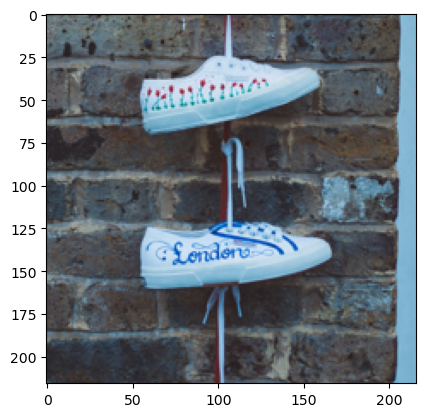

In [22]:
im = Image.open('DIV2K/0025.png')
transform = T.Compose([T.ToTensor(),T.ConvertImageDtype(torch.float32)])
im = T.CenterCrop(648)(im)
im = im.resize((216,216), resample=Image.BICUBIC)
im = transform(im)
plt.imshow(im.permute(1,2,0))

In [11]:
model.eval()

FSRCNN(
  (conv1): Conv2d(3, 48, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (conv2): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1), padding=same)
  (conv3): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv4): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
  (deconv): ConvTranspose2d(48, 3, kernel_size=(9, 9), stride=(3, 3), padding=(3, 3))
)

In [23]:
res = model(im.to(device))

In [24]:
im_out = res.detach().cpu().numpy()

In [25]:
im_out[im_out<0.] = 0.
im_out[im_out>1.] = 1.

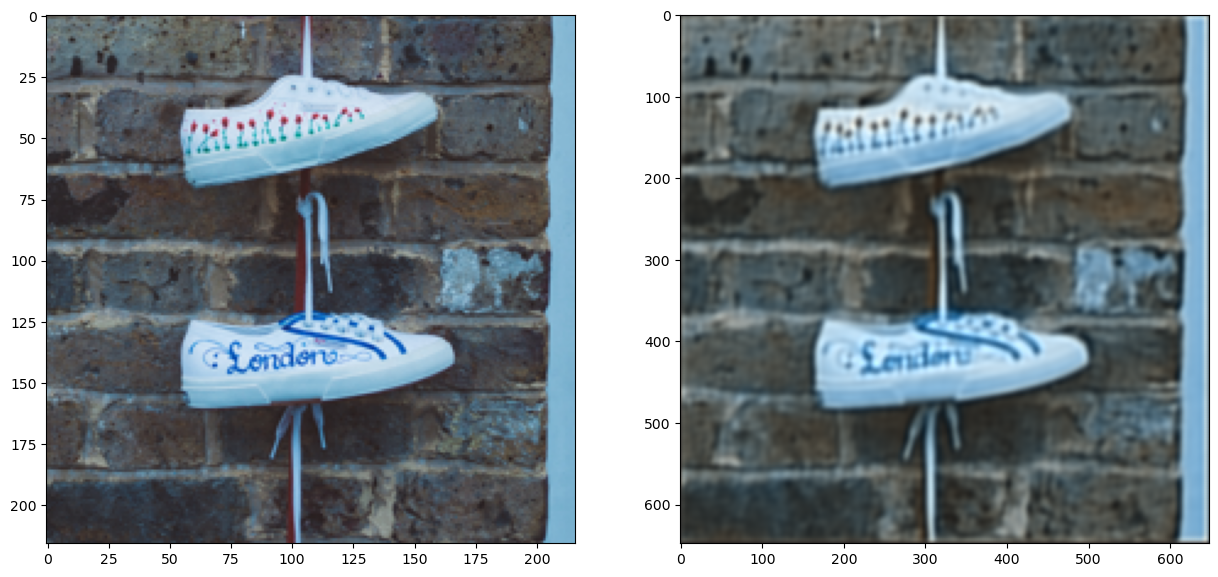

In [27]:
fig, ax = plt.subplots(1,2,figsize=(15,7))
ax[0].imshow(im.permute(1,2,0))
ax[1].imshow(im_out.transpose(1,2,0))